# CAB420, DCNNs, Additional Example 7: Runtimes
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will:
* Look at how fast (or slow) DCNNs are compared to:
  * CKNNs
  * SVMs
  * Random Forests

Why are we doing this? We've spent a bit of time saying how slow and demanding DCNNs are, so let's put that in perspective using a large number of samples of moderately high dimensional data.

### Is this example a good illustration of how to do image classification with non-DL methods?

**NO!!**

While the methods have some success in this example, this is not a great pipeline to use. Ideally, we'd have some sort of feature extraction out the front (maybe Local Binary Patterns, or Histograms of Orietanted Gradients, or a codebook built using SIFT or something similar). This however adds complexity, and distracts from the main focus of this example. Depending on the feature representation, it may also actually increase the feature dimension, which will further exacerbate the problems shown here.

### Should I run this myself? Or play with it? Or whatever?

Probably not.

This example really exists just to generate some plots for a video/slides. It takes quite a while to run, and borrows heavily from earlier examples from both DCNNs and Classifiers. it has nothing really new in it over other examples, and it's not really a teaching example. As note above, it's a way for me to generate some plots to illustrate runtimes as data volume changes. As such, comments are sparse.

In [ ]:
import os
import datetime
import numpy

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt

import time

## Fashion MNIST

We'll use Fashion MNIST here. DCNNs are best suited to signal data (images, audio, video, etc); so using tabular data like we've used earlier doesn't make a lot of sense. Similarly, using small dataset (like we've used earlier) doesn't make sense for a DCNN.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## DL Functions

This contains three functions to:
* Build a network
* Train a model
* Evaluate the model

The train and evaluation functions will also track run-times for training and prediction

In [37]:
def build_network():
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
    #model_cnn.summary()

    return model_cnn
    
def eval_model_dl(model, x_train, y_train, x_test, y_test, verbose = False):

    train_pred_start = time.process_time()
    pred = model.predict(x_train);
    train_pred_end = time.process_time()

    if (verbose):
        fig = plt.figure(figsize=[25, 8])
        ax = fig.add_subplot(1, 2, 1)

        indexes = tf.argmax(pred, axis=1)
        i = tf.cast([], tf.int32)
        indexes = tf.gather_nd(indexes, i)

        cm = confusion_matrix(y_train, indexes)
        c = ConfusionMatrixDisplay(cm, display_labels=range(10))
        c.plot(ax = ax)
        ax.set_title('Training Set Performance: ' + str(sum(indexes.numpy() == y_train)/len(y_train)));

    test_pred_start = time.process_time()
    pred = model.predict(x_test);
    test_pred_end = time.process_time()
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    test_acc = sum(indexes.numpy() == y_test)/len(y_test)

    if (verbose):
        ax = fig.add_subplot(1, 2, 2)

        cm = confusion_matrix(y_test, indexes)
        c = ConfusionMatrixDisplay(cm, display_labels=range(10))
        c.plot(ax = ax)
        ax.set_title('Testing Set Performance: ' + str(test_acc));

        print(classification_report(y_test, indexes))

    return (train_pred_end - train_pred_start), (test_pred_end - test_pred_start), test_acc
    
def train_and_eval_cnn(x_train, y_train, x_test, y_test, verbose = False):
    model_cnn = build_network()
    model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    dcnn_train_start = time.process_time()
    history = model_cnn.fit(x_train, y_train,
                            batch_size=64,
                            epochs=20,
                            validation_split=0.2, verbose=False)
    dcnn_train_end = time.process_time()
    dcnn_train_time = dcnn_train_end - dcnn_train_start

    dcnn_pred_train_time, dcnn_pred_test_time, test_acc = eval_model_dl(model_cnn, x_train, y_train, x_test, y_test, verbose)

    return dcnn_train_time, dcnn_pred_train_time, dcnn_pred_test_time, test_acc    

## Non-DL Functions

This contains two functions to:
* Train a non-DL model
* Evaluate the model

These are intended to work with SKLearn models that have the usual ``fit`` and ``predict`` functions.

The train and evaluation functions will also track run-times for training and prediction.

In [38]:
def eval_model_nondl(model, X_train, Y_train, X_test, Y_test, verbose = False):

    train_pred_start = time.process_time()
    pred = model.predict(X_train)
    train_pred_end = time.process_time()

    if (verbose):
        fig = plt.figure(figsize=[25, 8])
        ax = fig.add_subplot(1, 2, 1)
        conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)

        conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));

    test_pred_start = time.process_time()
    pred = model.predict(X_test)
    test_pred_end = time.process_time()
    test_acc = sum(pred == Y_test)/len(Y_test)

    if (verbose):
        ax = fig.add_subplot(1, 2, 2)
        conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
        conf.ax_.set_title('Testing Set Performance: ' + str(test_acc));

        print(classification_report(y_test, pred))
    
    return (train_pred_end - train_pred_start), (test_pred_end - test_pred_start), test_acc

def train_and_eval_nondl(model,x_train, y_train, x_test, y_test, verbose = False):

    train_start = time.process_time()
    model.fit(x_train, y_train)
    train_end = time.process_time()
    train_time = train_end - train_start

    pred_train_time, pred_test_time, acc = eval_model_nondl(model, x_train, y_train, x_test, y_test, verbose)
    
    return train_time, pred_train_time, pred_test_time, acc

## Bulk Evaluate Function

This will do all the heavy lifting, and train:
* A DCNN
* A CKNN
* A one vs all SVM
* A Random Forest

It will get run-times and testing accuracies for each. If you want to see a lot of plots, set ``verbose = True``.

In [70]:
def bulk_evaluate(x_train, y_train, x_test, y_test, verbose = False):
    
    x_train_vectorised = x_train.reshape(-1, 784).astype('float32')
    x_test_vectorised = x_test.reshape(-1, 784).astype('float32')
    
    dcnn_metrics = train_and_eval_cnn(x_train, y_train, x_test, y_test, verbose)
    
    cknn = KNeighborsClassifier(n_neighbors=20, weights='distance')
    cknn_metrics = train_and_eval_nondl(cknn, x_train_vectorised, y_train, x_test_vectorised, y_test, verbose)
    
    onevsall_svm = OneVsRestClassifier(SVC())
    svm_metrics = train_and_eval_nondl(onevsall_svm, x_train_vectorised, y_train, x_test_vectorised, y_test, verbose)    
    
    rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
    rf_metrics = train_and_eval_nondl(rf, x_train_vectorised, y_train, x_test_vectorised, y_test, verbose)    
    
    return dcnn_metrics, cknn_metrics, svm_metrics, rf_metrics

We'll now run a number of evaluations with different size datasets.

In [71]:
dcnn_500, cknn_500, svm_500, rf_500 = bulk_evaluate(x_train[0:500, :, :], y_train[0:500], x_test, y_test, False)
dcnn_1000, cknn_1000, svm_1000, rf_1000 = bulk_evaluate(x_train[0:1000, :, :], y_train[0:1000], x_test, y_test, False)
dcnn_2000, cknn_2000, svm_2000, rf_2000 = bulk_evaluate(x_train[0:2000, :, :], y_train[0:2000], x_test, y_test, False)
dcnn_5000, cknn_5000, svm_5000, rf_5000 = bulk_evaluate(x_train[0:5000, :, :], y_train[0:5000], x_test, y_test, False)
dcnn_10000, cknn_10000, svm_10000, rf_10000 = bulk_evaluate(x_train[0:10000, :, :], y_train[0:10000], x_test, y_test, False)
dcnn_20000, cknn_20000, svm_20000, rf_20000 = bulk_evaluate(x_train[0:20000, :, :], y_train[0:20000], x_test, y_test, False)
dcnn_50000, cknn_50000, svm_50000, rf_50000 = bulk_evaluate(x_train[0:50000, :, :], y_train[0:50000], x_test, y_test, False)

And plot some results.

In [74]:
dcnn_results = numpy.vstack([dcnn_500, dcnn_1000, dcnn_2000, dcnn_5000, dcnn_10000, dcnn_20000, dcnn_50000])
cknn_results = numpy.vstack([cknn_500, cknn_1000, cknn_2000, cknn_5000, cknn_10000, cknn_20000, cknn_50000])
svm_results = numpy.vstack([svm_500, svm_1000, svm_2000, svm_5000, svm_10000, svm_20000, svm_50000])
rf_results = numpy.vstack([rf_500, rf_1000, rf_2000, rf_5000, rf_10000, rf_20000, rf_50000])
samples = [500, 1000, 2000, 5000, 10000, 20000, 50000]

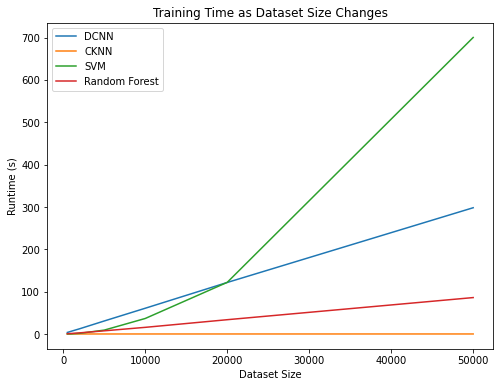

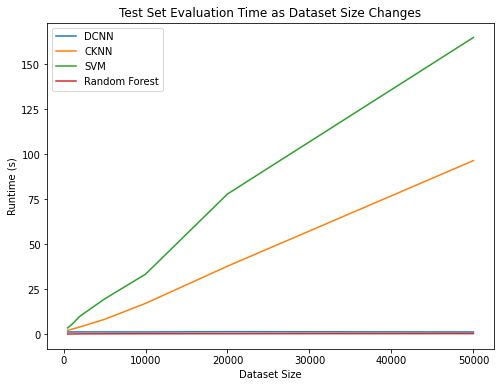

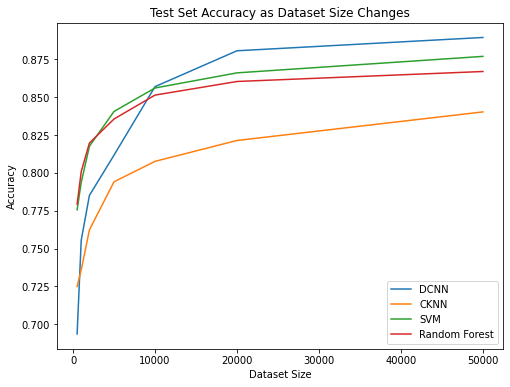

In [77]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(samples, dcnn_results[:,0], label='DCNN')
ax.plot(samples, cknn_results[:,0], label='CKNN')
ax.plot(samples, svm_results[:,0], label='SVM')
ax.plot(samples, rf_results[:,0], label='Random Forest')
ax.set_title('Training Time as Dataset Size Changes')
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Runtime (s)')
ax.legend()

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(samples, dcnn_results[:,2], label='DCNN')
ax.plot(samples, cknn_results[:,2], label='CKNN')
ax.plot(samples, svm_results[:,2], label='SVM')
ax.plot(samples, rf_results[:,2], label='Random Forest')
ax.set_title('Test Set Evaluation Time as Dataset Size Changes')
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Runtime (s)')
ax.legend()

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(samples, dcnn_results[:,3], label='DCNN')
ax.plot(samples, cknn_results[:,3], label='CKNN')
ax.plot(samples, svm_results[:,3], label='SVM')
ax.plot(samples, rf_results[:,3], label='Random Forest')
ax.set_title('Test Set Accuracy as Dataset Size Changes')
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Accuracy')
ax.legend()

What we see is:
* For all models, more data gives better accuracy. Though in all cases we also see diminishing returns.
* Training increases linearly with dataset size for the DCNN, CKNN and RF. CKNNs are also very fast to train (remember, nothing is actually learned here).
* SVM training gets slow with large dataset sizes. These do not scale well.
* Time taken for evaluation for the DCNN and RF does not depend on the dataset size.
* CKNN and SVM evaluation times increase roughly linearly with the dataset size.

Overall once we consider training and evaluation times, the DCNN doesn't look so bad. It's the most accurate, and is only really beaten by the Random Forest in terms of runtimes.

We could make the DCNN slower by making it bigger, but this would also increase it's accuracy. Does this mean that commentary on how demanding DCNNs are is inaccurate? No, not really. The are computionally demanding, and they do need a lot of data to achieve good results, but many other methods will also be very slow (if not slower) when confronted with very large datasets, and they may not be as accurate.